## Домашнее задание к уроку №7

1. К алгоритму kNN, представленному на уроке, реализуйте добавление весов для соседей по любому из показанных на уроке принципов. Сравните точность нового алгоритма с исходным при разных значениях k.

Повторим реализацию алгоритма kNN из урока и загрузим тренировочный датасет.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [4]:
def e_metrics(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей без учета весов соседей.

In [5]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # отберем k ближайших соседей
        k_neighbours = sorted(test_distances)[0:k]
                
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in k_neighbours:
            classes[d[1]] += 1 # вес каждого соседа равен 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Теперь скорректируем эту функцию с учетом веса соседа по его номеру.

In [25]:
def knn_w(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # отберем k ближайших соседей
        k_neighbours = sorted(test_distances)[0:k]
                
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for n, d in enumerate(k_neighbours):
            classes[d[1]] += 0.9**n # вес каждого соседа определяется в соответствии с его номером (т.е. близостью)
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности:

In [9]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [17]:
accuracy_knn = []
for k in range(1, 11):
    y_pred = knn(X_train, y_train, X_test, k)
    accuracy_knn.append(accuracy(y_pred, y_test))
accuracy_knn

[0.6666666666666666,
 0.6666666666666666,
 0.7333333333333333,
 0.8333333333333334,
 0.8666666666666667,
 0.8333333333333334,
 0.8,
 0.8,
 0.8666666666666667,
 0.8333333333333334]

Проделаем то же самое для алгоритма с учетом весов:

In [26]:
accuracy_knn_w = []
for k in range(1, 11):
    y_pred = knn_w(X_train, y_train, X_test, k)
    accuracy_knn_w.append(accuracy(y_pred, y_test))
accuracy_knn_w

[0.6666666666666666,
 0.6666666666666666,
 0.7333333333333333,
 0.7333333333333333,
 0.8666666666666667,
 0.8333333333333334,
 0.8333333333333334,
 0.8,
 0.8666666666666667,
 0.8666666666666667]

Визуализируем результаты:

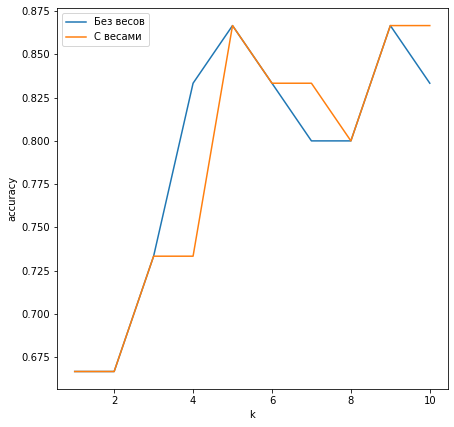

In [31]:
plt.figure(figsize=(7,7))
plt.plot(range(1, 11), accuracy_knn, label = 'Без весов')
plt.plot(range(1, 11), accuracy_knn_w, label = 'С весами')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Как видно из графиков, различия в качестве алгоритмов проявляется только при росте k.

2. (*) Напишите функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и постройте график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

Сгенерируем датасет из урока.

In [32]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

Реализуем основной цикл алгоритма.

In [34]:
def kmeans(data, k, max_iterations, min_distance):
       
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

Функция подсчета метрики качества кластеризации как среднего квадратичного внутрикластерного расстояния.

In [41]:
def sq_distance(k):
    centroids, classes = kmeans(X, k, max_iterations, min_distance)
    distance = 0
    for i in classes:
        distance += sum(classes[i])**2
    return distance / k